Calibrating camera ...
Progress:  0.0 %
Progress:  5.0 %
Progress:  10.0 %
Progress:  15.0 %
Progress:  20.0 %
Progress:  25.0 %
Progress:  30.0 %
Progress:  35.0 %
Progress:  40.0 %
Progress:  45.0 %
Progress:  50.0 %
Progress:  55.00000000000001 %
Progress:  60.0 %
Progress:  65.0 %
Progress:  70.0 %
Progress:  75.0 %
Progress:  80.0 %
Progress:  85.0 %
Progress:  90.0 %
Progress:  95.0 %
Calibration success =  True


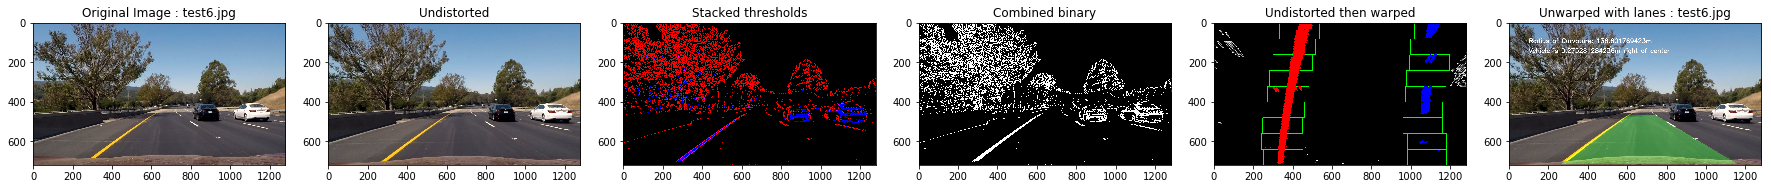

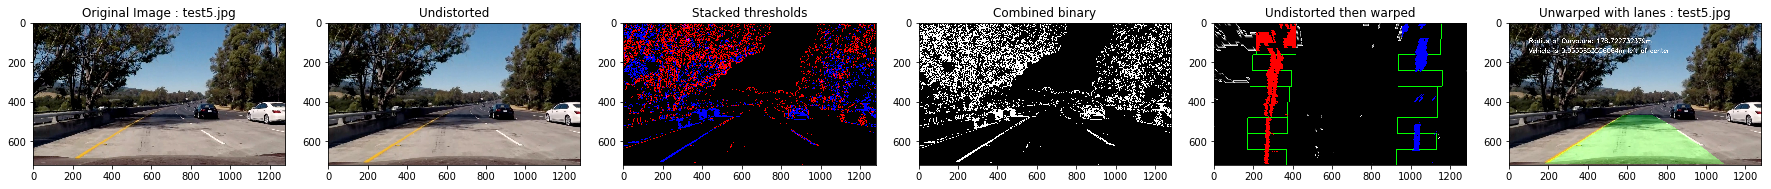

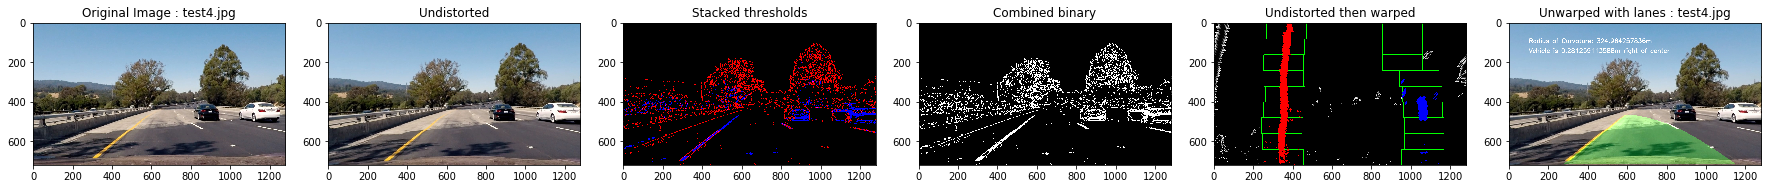

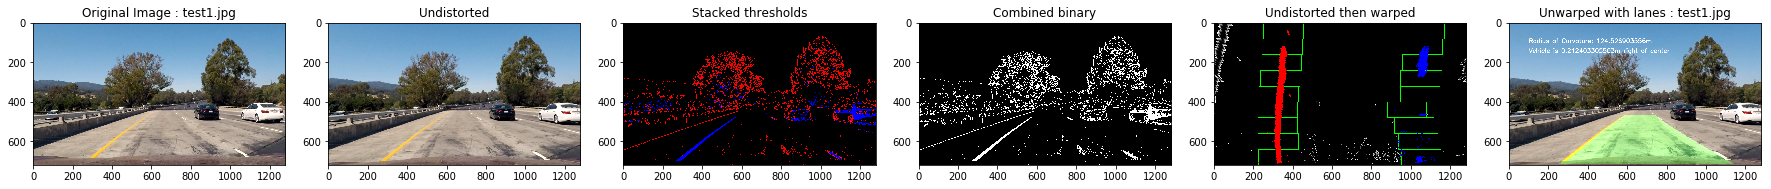

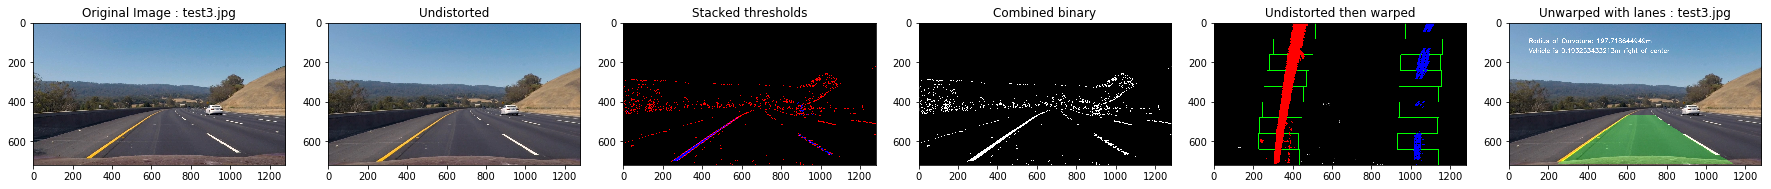

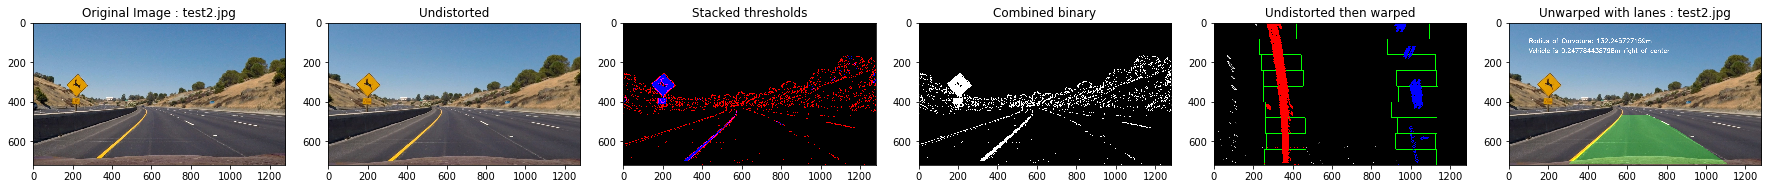

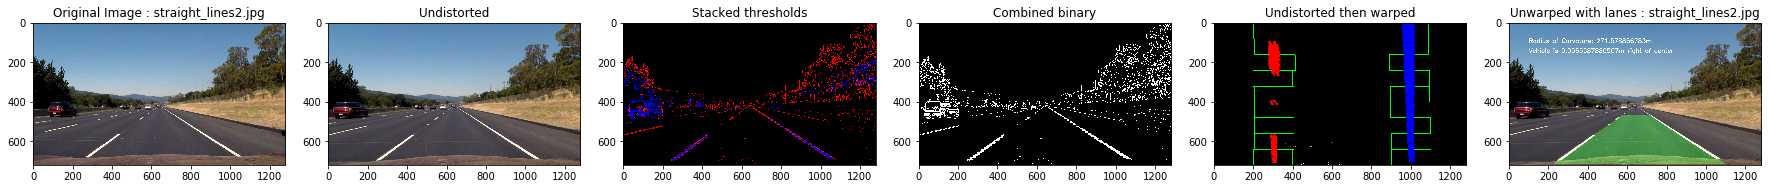

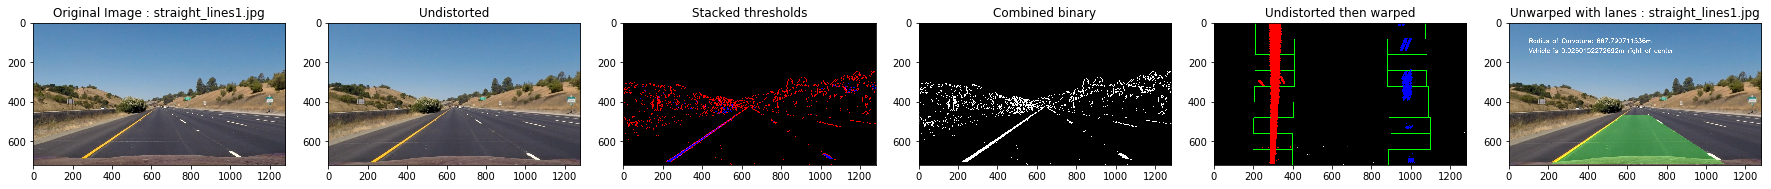

In [11]:
# Vinh Nghiem
# P4.ipynb
## import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mtx= None
dist = None


def calibrate_camera(directory, nx, ny):

    file_names = os.listdir(directory + "/")

    objpoints = []
    imgpoints = []

    #Prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    print ("Calibrating camera ...")
    for i, file_name in enumerate(file_names):
        img = mpimg.imread(directory + "/" + file_name)
        print ("Progress: ", float(i)/len(file_names)*100, "%")

        #Find chessboard corners
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret==True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
    if len(imgpoints)>0:        
        return True, cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    else:
        return False, (None,None,None,None,None)

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def get_sobel_binary(img,type='x', thresh=(20,100)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if type=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    if type == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    if type == 'mag':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sobel_binary

def get_s_binary(img, thresh = (170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]  
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

def combine_binary(sobel_binary, s_binary):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.dstack(( combined_binary, combined_binary, combined_binary)) * 255

    return combined_binary
  
def mark_lanes(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Display lanes on warped image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty

def unwarp_with_lanes(warped, undistorted_img, left_fitx, right_fitx, ploty, dest, src):
    # warped binary image called warped, and the lines fitted with a 
    # polynomial and have arrays called ploty, left_fitx and right_fitx, 
    # which represent the x and y pixel values of the lines. 

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dest, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1.0, newwarp, 0.3, 0)
    
    #plt.imshow(result)
    return result

class Road:
    def __init__(self):
        self.first = True
        self.left_x = None
        self.right_x = None
        self.lane_offset = 0.0
        
    def update(self, left_x, right_x, offset):
        self.left_x = left_x
        self.right_x = right_x
        self.lane_offset = offset
        self.first = False
        
def sanity_test_passed(left_x, right_x, offset):
    #lanes parallel
    parallel_tolerance = 100
    
    lanes_parallel = abs ( abs(left_x[0]-right_x[0]) - abs(left_x[-1]-right_x[-1]) ) < parallel_tolerance 
    
    # in center
    center_tolerance = 0.2
    kept_center = abs(offset - prev_road.lane_offset) < center_tolerance
    
    return lanes_parallel and kept_center

def detect_lanes_in_image(img):
    undistorted = undistort(img, mtx, dist)
 
    sobel_binary = get_sobel_binary(undistorted, thresh = (20,100))
    s_binary = get_s_binary(undistorted, thresh = (170, 255))

    combined_binary = combine_binary(sobel_binary, s_binary)

    color_binary = np.dstack((sobel_binary, np.zeros_like(sobel_binary), s_binary)) * 255


    src = np.float32([[568,468],[717,468],[1077,717],[217, 717]])
 
    offset = 300
    img_size = (undistorted.shape[1], undistorted.shape[0])
    
    dest = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dest)
    
    warped = cv2.warpPerspective(undistorted, M, img_size)

    warped_binary = cv2.warpPerspective(combined_binary, M, img_size)

    warped_binary_with_lanes, left_fitx, right_fitx, ploty = mark_lanes(warped_binary[:,:,0])
    
    rad_curv_left, rad_curv_right, off_center = get_rad_curv(left_fitx, right_fitx, ploty, img_size)
    rad_curv = (rad_curv_left+rad_curv_right)/2.0
    
    if prev_road.first==True or sanity_test_passed(left_fitx, right_fitx, off_center) == True:     
 #       print ("sanity test passed!")
        unwarped_with_lanes = unwarp_with_lanes(warped_binary[:,:,0], undistorted, left_fitx, right_fitx, ploty, dest, src) 
        prev_road.update(left_fitx, right_fitx, off_center)
    
    else:
 #       print ("sanity test failed! I am insane!")
        unwarped_with_lanes = unwarp_with_lanes(warped_binary[:,:,0], undistorted, prev_road.left_x, prev_road.right_x, ploty, dest, src) 
        rad_curv_left, rad_curv_right, off_center = get_rad_curv(prev_road.left_x, prev_road.right_x, ploty, img_size)
        rad_curv = (rad_curv_left+rad_curv_right)/2.0
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(unwarped_with_lanes,'Radius of Curvature: '+str(rad_curv_left)+"m",(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)

    if (off_center<0):
        cv2.putText(unwarped_with_lanes,'Vehicle is '+str(abs(off_center))+"m left of center",(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(unwarped_with_lanes,'Vehicle is '+str(abs(off_center))+"m right of center",(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)


        
    return undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right
  
def process_img(img):
    undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
    return unwarped_with_lanes

def get_rad_curv(leftx, rightx, ploty, img_size):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    
    ym_per_pix = 3.048/220 # meters per pixel in y dimension (vertical length of a dashed line is 3.048m)
    xm_per_pix = 3.7/680 # meters per pixel in x dimension (horizontal width of a lane is 3.7m)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate where vehicle is off-center
    off_center  = ((rightx[-1] + leftx[-1])/2.0 - img_size[0]/2.0) * xm_per_pix
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad, off_center
    
##############################################################

from pylab import savefig
import os

calibration_directory = 'camera_cal'
test_directory = 'test_images'
output_directory = 'output_images'
#warp_image_file = "test_images/test2.jpg"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

source_points = []
dest_points = []
calibration_success, (retVal, mtx, dist, rvecs, tvecs) = calibrate_camera(calibration_directory, nx, ny) 
prev_road = Road()

print ('Calibration success = ', calibration_success) 
if calibration_success==True: 
    for file_name in os.listdir(test_directory): 
        img = mpimg.imread(test_directory + '/' + file_name)
        undistorted, color_binary, combined_binary, warped_binary_with_lanes, unwarped_with_lanes, rad_curv_left, rad_curv_right = detect_lanes_in_image(img)
        rad_curv = (rad_curv_left+rad_curv_right)/2.0
    
        # ################ Plotting starts here


        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 9))
        fig.tight_layout()

        ax1.imshow(img)
        ax1.set_title('Original Image : ' + file_name)
        
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted')

        ax3.set_title('Stacked thresholds')
        ax3.imshow(color_binary)

        ax4.set_title('Combined binary')
        ax4.imshow(combined_binary)

        ax5.set_title('Undistorted then warped')
        #ax4.imshow(warped)
        ax5.imshow(warped_binary_with_lanes)

        ax6.set_title('Unwarped with lanes : ' + file_name)
        ax6.imshow(unwarped_with_lanes)
        
        cv2.imwrite('output_images/' + file_name, cv2.cvtColor(unwarped_with_lanes, cv2.COLOR_RGB2BGR))

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_road.first = True
test_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("test_videos/project_video.mp4")
frame_clip = video_clip.fl_image(process_img) #NOTE: this function expects color images!!
%time frame_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:50<00:00,  4.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 5min 43s, sys: 45.2 s, total: 6min 28s
Wall time: 4min 52s


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_road.first = True
test_output = 'output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_clip = VideoFileClip("test_videos/harder_challenge_video.mp4")
frame_clip = video_clip.fl_image(process_img) #NOTE: this function expects color images!!
%time frame_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:14<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 6min 1s, sys: 46.2 s, total: 6min 47s
Wall time: 5min 17s
